<h1>Setup</h1>

In [244]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chisquare

In [245]:
# Constants
alpha = 0.05

In [246]:
spy = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True, header=0)
n100 = pd.read_csv('^N100.csv', index_col='Date', parse_dates=True, header=0)

eur_to_usd = pd.read_csv('EURUSD=X.csv', index_col='Date', parse_dates=True, header=0)

# normalize n100 by converting to USD
n100_normalized = pd.DataFrame()
n100_normalized['Close'] = n100['Close'] * eur_to_usd['Close']
n100_normalized.dropna(inplace=True)

In [247]:
# remove null values
spy.dropna(inplace=True)
n100.dropna(inplace=True)

In [248]:
# create pct columns, tracking the percentage change from the first day
start_date = n100.index[0]
spy_1 = spy['Close'][start_date]
spy['pct'] = (spy['Close'] / spy_1) - 1

n100_1 = n100['Close'][start_date]
n100['pct'] = (n100['Close'] / n100_1) - 1

<h1>Graphs</h1>

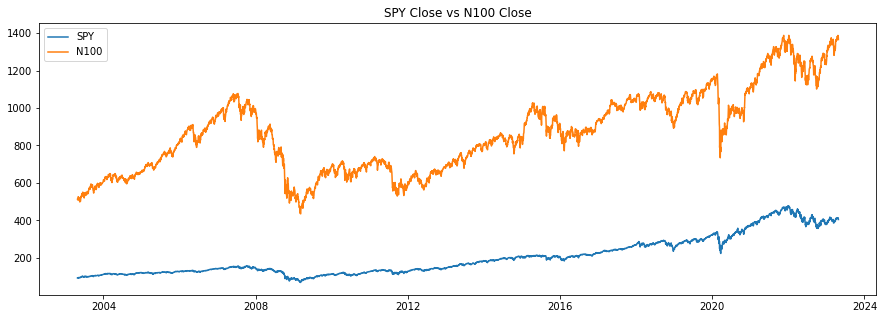

In [249]:
plt.figure(figsize=(15, 5))
plt.plot(spy['Close'], label='SPY')
plt.plot(n100['Close'], label='N100')
plt.legend(loc='upper left')
plt.title('SPY Close vs N100 Close')
plt.show()

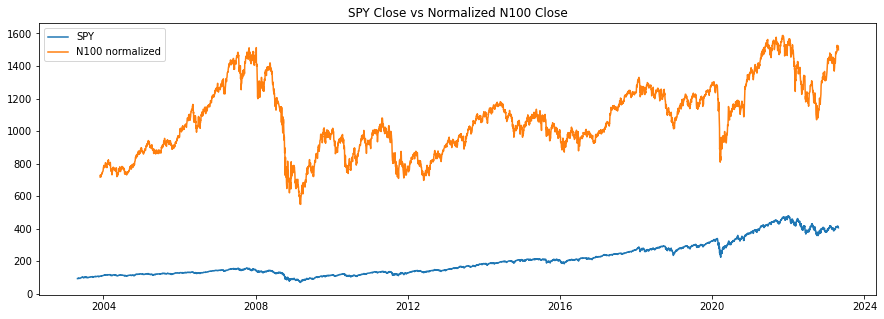

In [250]:
plt.figure(figsize=(15, 5))
plt.plot(spy['Close'], label='SPY')
plt.plot(n100_normalized['Close'], label='N100 normalized')
plt.legend(loc='upper left')
plt.title('SPY Close vs Normalized N100 Close')
plt.show()

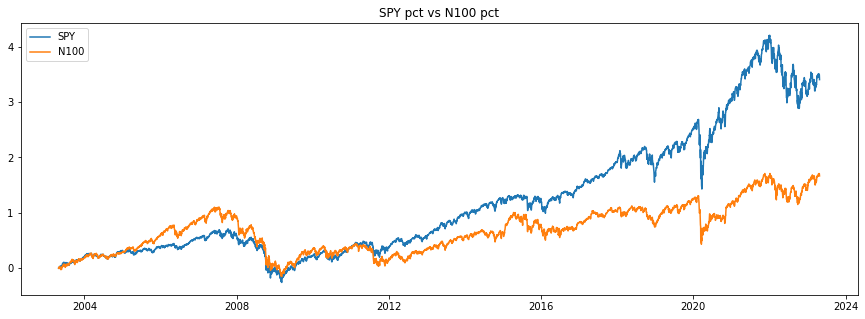

In [251]:
plt.figure(figsize=(15, 5))
plt.plot(spy['pct'], label='SPY')
plt.plot(n100['pct'], label='N100')
plt.legend(loc='upper left')
plt.title('SPY pct vs N100 pct')
plt.show()

The discrepancy in the values could be a result of changes in currency (SPY in USD and ^N100 in EUR), and other economic factors.


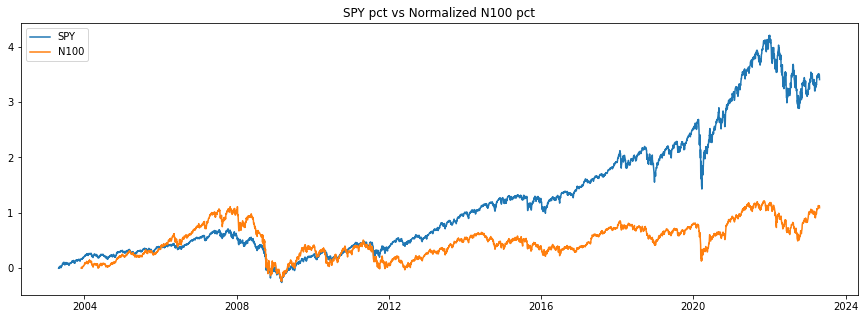

In [252]:
n100_normalized['pct'] = (n100_normalized['Close'] / n100_normalized['Close'][0]) - 1
plt.figure(figsize=(15, 5))
plt.plot(spy['pct'], label='SPY')
plt.plot(n100_normalized['pct'], label='N100')
plt.legend(loc='upper left')
plt.title('SPY pct vs Normalized N100 pct')
plt.show()

N100 percentage is normalized for currency exchange rate

Truncate this data for Goodness-of-fit so df <= 30 and result will not be skewed

<h1>Test for Independence</h1>

In [253]:
spy_ups = 0
spy_downs = 0
last = list(spy.index)[0]
for d in list(spy.index)[1:]:
    if spy['Close'][d] > spy['Close'][last]:
        spy_ups += 1
    elif spy['Close'][d] < spy['Close'][last]:
        spy_downs += 1
    last = d

In [254]:
n100_ups = 0
n100_downs = 0
last = list(n100.index)[0]
for d in list(n100.index)[1:]:
    if n100['Close'][d] > n100['Close'][last]:
        n100_ups += 1
    elif n100['Close'][d] < n100['Close'][last]:
        n100_downs += 1
    last = d

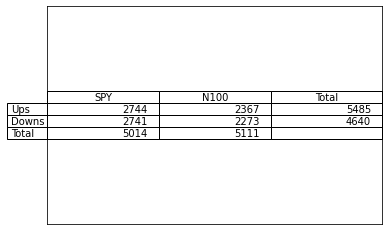

In [255]:
table = plt.table(cellText=[[n100_ups, n100_downs, spy_ups + n100_ups], [spy_ups, spy_downs, spy_downs + n100_downs], [spy_ups + spy_downs, n100_ups + n100_downs, None]],
                    rowLabels=['Ups', 'Downs', 'Total'],
                    colLabels=['SPY', 'N100', 'Total'],
                    loc='center')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, top=False, right=False)

In [256]:
chi_square_test = 0
overall_total = spy_ups + spy_downs + n100_ups + n100_downs
e1 = (spy_ups + n100_ups) * (spy_ups + spy_downs) / overall_total
e2 = (n100_ups + n100_downs) * (spy_ups + n100_ups) / overall_total
e3 = (spy_ups + spy_downs) * (spy_downs + n100_downs) / overall_total
e4 = (spy_downs + n100_downs) * (n100_ups + n100_downs) / overall_total
chi_square_test += (spy_ups - e1) ** 2 / e1
chi_square_test += (n100_ups - e2) ** 2 / e2
chi_square_test += (spy_downs - e3) ** 2 / e3
chi_square_test += ((n100_downs - e4) ** 2) / e4
chi_square_test

0.9767568807123299

Note- Yates' correction for continuity could be used here, but the values are so large that it would not make a difference.

In [257]:
import scipy.stats
chi_square_critical = scipy.stats.chi2.ppf(1-alpha, df=1)
chi_square_critical

3.841458820694124

H_0 = "The number of up days and down days in the SPY and N100 are independent"<br>
H_1 = "The number of up days and down days in the SPY and N100 are not independent (thus dependent)"

In [258]:
if (chi_square_test < chi_square_critical):
    print('Reject Null Hypothesis')
else:
    print('Fail to Reject Null Hypothesis')

Reject Null Hypothesis


Thus, the number of up days and down days in the SPY and N100 are dependent.

<h1>Goodness-of-Fit</h1>

In [259]:
time_interval = pd.offsets.MonthBegin(9)
aggregated_spy = spy['pct'].resample(time_interval).mean()
aggregated_n100 = n100['pct'].resample(time_interval).mean()
len(aggregated_spy), len(aggregated_n100)

(27, 27)

samples are both n=27, so df = 26

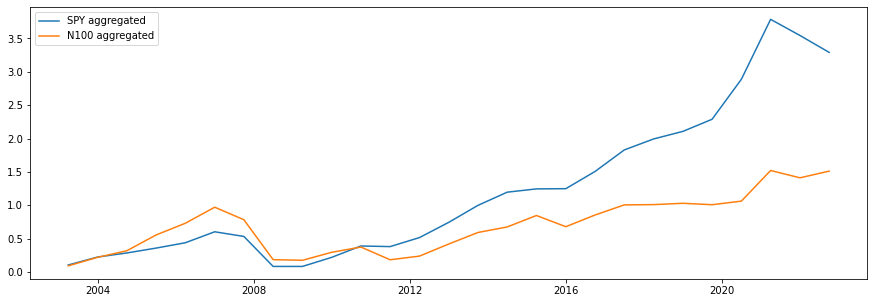

In [260]:
plt.figure(figsize=(15, 5))
plt.plot(aggregated_spy, label='SPY aggregated')
# plt.plot(spy['pct'], label='SPY1')
plt.plot(aggregated_n100, label='N100 aggregated')
# plt.plot(n100['pct'], label='N1001')
plt.legend(loc='upper left')

In [261]:
s = 0
for d in list(aggregated_spy.index):
    if d not in list(aggregated_n100.index):
        continue
    expected = aggregated_spy[d]
    observed = aggregated_n100[d]
    if expected != 0.0:
        s += (observed - expected) ** 2 / expected
print("Chi-square test statistic: ", s)

Chi-square test statistic:  9.232653534107431


H0: The N100 is a good predictor of the SPY (good fit)<br>
H1: The N100 is not a good predictor of the SPY (not a good fit)

Chi-square critical value for df=26 and alpha=0.05 is <strong>38.885</strong><br>
Chi-square test value is <strong>9.232653534107431</strong><br>
Chi-square test < chi-square critical value, so we fail to reject H0<br>
Thus, there is <strong>insufficient evidence to say that the N100 is not a good predictor of SPY</strong>

<h1>Variance (F-test)</h1>

In [262]:
spy['pct'].var(), n100_normalized['pct'].var()

(1.2171423591440305, 0.0922353803975381)

In [263]:
sample1_variance = spy['pct'].var()
sample2_variance = n100_normalized['pct'].var()

f_test = sample1_variance / sample2_variance
f_test

13.19604639670915

In [264]:
f_critical_1 = scipy.stats.f.ppf(q=1-alpha, dfn=spy['pct'].count()-1, dfd=n100_normalized['pct'].count()-1)
f_critical_2 = scipy.stats.f.ppf(q=alpha, dfn=spy['pct'].count()-1, dfd=n100_normalized['pct'].count()-1)
f_critical_1, f_critical_2

(1.0477094576858823, 0.9544748950183299)

f_test is outside of the range of the critical value, so we reject the null hypothesis that the variances are equal<br>
thus, the variances are not equal

<h1>Conclusion</h1>

The number of up days and down days in the SPY and N100 are dependent, indicating that they may react to similar global events and economic factors on a daily basis<br>
Goodness-of-fit test concluded that the N100 is a good predictor of the SPY, indicating that they follow a similar trend<br>
Variance test concluded that the variances are not equal, indicating that there is a difference in the volatility of the two indices<br>